In [1]:
import utilities2 as ut2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Methods 1 - A model set

According to the goals of the study we need to calculate the range of alkalinity fluxes at the sediment-water interface (SWI) and the corresponding variations in the water column of the Wadden Sea.
For calculations we use the software written in Fortran.
It consist of:
1) a governing program resolving a transport equation (diffusive and vertical advective terms) between and within water column and sediments plus horizontal exchange with an external pool - the 1-D Sympagic-Pelagic-Benthic transport Model, SPBM (Yakubov et al., 2019); 
2) a biogeochemical model part sending sources minus sinks to the transport equation governing program.
The SPBM and biogeochemical model are linked through the Framework for Aquatic Biogeochemical Models, FABM (Bruggeman and Bolding, 2014).


The transport and biogeochemical models operate with the following *state variables*:
autotrophs ($\text{Phy}$), heterotrophs ($\text{Het}$), $\text{NH}_{4}^{+}$, $\text{NO}_{2}^{-}$, $\text{NO}_{3}^{-}$,
$\text{Si}$, $\text{PO}_{4}^{3 -}$, $O_{2}$, $\text{SO}_{4}^{2 -}$, $\text{S}_{2}O_{3}^{2 -}$, $\text{S}^{0}$, $\text{H}_{2}\text{S}$, dissolved inorganic carbon
($\text{DIC}$), dissolved OM ($\text{DOM}$), particulate OM ($\text{POM}$), and total alkalinity ($\text{TA}$).
$\text{Phy}$, $\text{Het}$, and $\text{POM}$ are particulates and have an ability to sink.

#### The grid

For calculations we should at first determine the grid we want to use as a proxy of the Wadden Sea.
Assuming a mean depth of the Wadden Sea of 2.5 m (van Beusekom et al., 1999), we split the water domain into two layers
of 1.25 m and 1.15 m depth.
Near the bottom, we have a benthic boundary layer (BBL) consisting of 2 layers of 0.05 m depth each.
The BBL is a layer with eddy diffusion coefficients decreasing linearly to zero at the SWI.
The sediment domain has 40 layers of 0.01 m depth each.
Therefore, to study sedimentary alkalinity generation in the Wadden Sea we use the vertically resolved box containing the water domain and sediment domain.

![Image](Grid.png "icon")

The transport program (SPBM) updates the concenstrations of the state variables in the center of each layer due to sources minus sinks terms from the biogeochemical model, diffusive and advective terms plus horizontal exchange with an external pool each time step (300 sec).


#### Forcing, initial and boundary conditions

The functioning of the transport and the biogeochemical models needs some forcing (for example, to calculate souces minus sinks terms the biogeochemical model requires data of seawater temperature, salinity, and photosynthetically active radiation (PAR)), also we have to establish state variables initial conditions and conditions on the boundaries of the modeling box.
The data for forcing (seawater temperature, salinity, density) and initial conditions are averaged to one year from the World Ocean Database (WOD) for the years 2000 - 2010 from a rectangular region (the Southern North Sea, 54.35-55.37$^{\circ}$N 6.65-8.53$^{\circ}$E) that is adjacent to the North Frisian Wadden Sea.
The data from WOD are stored in `wadden_sea.nc` file.
The data of Chlorophyll a are taken from Loebl et al. (2007).
The data of $\text{NH}_{4}^{+}$ are taken from van Beusekom et al. (2009).
Boundary conditions are set up for carbon and $O_{2}$ at the surface boundary as an exchange with the atmosphere according to (Yakushev et al., 2017).
For all other species, boundary conditions at the bottom and the surface interfaces of the model box are set to zero fluxes.

For diffusive updates SPBM needs to know the vertical diffusion coefficients in the water column and the dispersion coefficients in sediments (which are analogs to vertical diffusion coefficients in the water column).
The vertical diffusion coefficients in the water column are calculated according to the vertical density distributions following Gargett (1984).
Vertical advective updates in the water column (sinking of the particles) are calculated according to sinking velocities of particles.
The dispersion coefficients in sediments and sinking velocities of particles are discussed in Methods 3.
Vertical advective updates in the sediments (burification) are neglected (no burification).

SPBM also calculates state variables horizontal exchange with an external pool and allochthonous organic matter influx to the modelling box.
*Horizontal exchange.*
To supply the model water domain with nutrients for the proper functioning of the phytoplankton model, we introduce an horizontal exchange of phosphates, ammonium, nitrates, and silicates with external concentrations (data from the World Ocean Database and van Beusekom et al. (2009)) controlled by the horizontal diffusivity coefficient$\ K_{h}$ (Okubo, 1976).
Along with concentrations of the corresponding elements, phosphate, ammonium and nitrate exchange also affect alkalinity according to Eq. 1.
*Organic matter influx.* To reflect the heterotrophic nature of the Wadden Sea (van Beusekom et al., 1999) we add an additional advective influx of $\text{POM}$.
This $\text{POM}$ input is adopted from the value for the net import of OM to the Sylt-Rømø basin in the North Frisian Wadden Sea (110 $g\ m^{- 2}\ \text{year}^{- 1}$) reported in (van Beusekom et al., 1999) as a sinusoidal curve with a maximum in May (Joint and Pomroy, 1993; de Beer et al., 2005).
This value is also close to the Wadden Sea average OM input (100 $g\ m^{- 2}\ \text{year}^{- 1}$) from the North Sea (van Beusekom et al., 1999).

`s_1_generate_netcdf.ipynb` reads the data from WOD (`wadden_sea.nc`) and forms another NetCDF data file `wadden_sea_out.nc` with the data filtered and averaged to one year, calculated diffusion coefficients, calculated theoretical surface PAR values for the region of the Wadden Sea, and calculated OM influx.
The governing program SPBM uses `wadden_sea_out.nc` to get all nessesary information. There is an ipython notebook to check the data written in `wadden_sea_out.nc` - `s_2_check_data.ipynb`

#### Preliminary evaluations

In introduction we noticed the equation to describe which processes can contribute to alkalinity change.
There are thirteen terms in it and the most abundant biogeochemical processes in the coastal ocean can change the concentrations of six of them:
$2\lbrack\text{Ca}^{2 +}\rbrack, \text{TNH}_{3}, \lbrack\text{NO}_{3}^{-}\rbrack, \text{TPO}_{4}, 2\text{TSO}_{4}, \text{THNO}_{2}$.
Now we can try to estimate which of them can be the most important ones.
At first we can write down the mean concentrations of alkalinity and the mentioned compounds in the area of interest.

In [2]:
par, temperature, no3, ammonium, po4, si, irradiance = ut2.get_data() # it takes data from wadden_sea_out.nc

In [3]:
NH4 = ammonium.mean(); NO3 = no3.mean(); PO4 = po4.mean()
print('NH4={0}; NO3={1}, PO4={2}'.format(NH4, NO3, PO4))

NH4=3.43013698630137; NO3=16.124231302432, PO4=0.6163383757363852


TA we will assume to be equal 2300, $\text{Ca}^{2 +}$ and $\text{TSO}_{4}$ are the mayor ions of seawater:

In [4]:
Ca = 10000; SO4 = 25000

At first, we will try to understand how the biogeochemical reactions involving $\text{Ca}^{2 +}$ can affect TA.

In [18]:
def alk_change(TA, dCa=0, dSO4=0, dNH4=0, dNO3=0, dPO4=0):
    return TA + 2*dCa - 2*dSO4 + dNH4 - dNO3 - dPO4

In [19]:
def sinusoidal(max_value):
    day=np.arange(0,365,1)
    return (1/2)*max_value*(1+np.sin(2*np.pi*((day-90)/365)))

In [20]:
dCa = -sinusoidal(100)
Ca_year = Ca + dCa
TA_year = alk_change(TA = 2300, dCa = dCa)

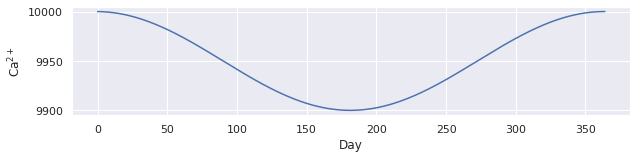

In [21]:
plt.plot(np.arange(0,365,1), Ca_year); plt.gcf().set_size_inches(10, 2);
plt.xlabel('Day'); plt.ylabel('Ca$^{2+}$');

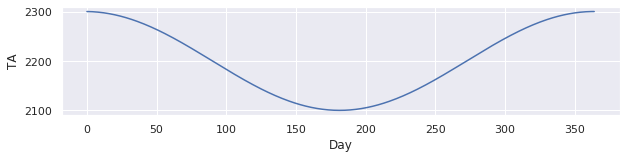

In [22]:
plt.plot(np.arange(0,365,1), TA_year); plt.gcf().set_size_inches(10, 2);
plt.xlabel('Day'); plt.ylabel('TA');

In [23]:
dSO4 = -sinusoidal(100)
SO4_year = SO4 + dSO4
TA_year = alk_change(TA = 2300, dSO4 = dSO4)

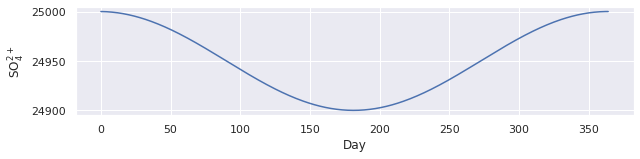

In [24]:
plt.plot(np.arange(0,365,1), SO4_year); plt.gcf().set_size_inches(10, 2);
plt.xlabel('Day'); plt.ylabel('SO$_4^{2+}$');

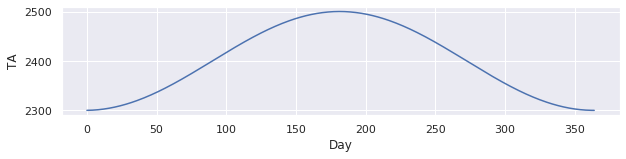

In [25]:
plt.plot(np.arange(0,365,1), TA_year); plt.gcf().set_size_inches(10, 2);
plt.xlabel('Day'); plt.ylabel('TA');

In [27]:
dNO3 = -sinusoidal(NO3)
NO3_year = NO3 + dNO3
TA_year = alk_change(TA = 2300, dNO3 = dNO3)

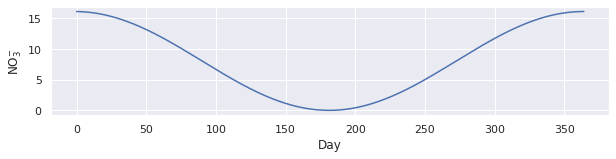

In [28]:
plt.plot(np.arange(0,365,1), NO3_year); plt.gcf().set_size_inches(10, 2);
plt.xlabel('Day'); plt.ylabel('NO$_3^{-}$');

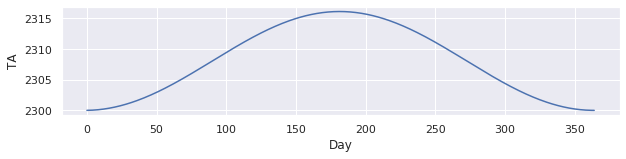

In [29]:
plt.plot(np.arange(0,365,1), TA_year); plt.gcf().set_size_inches(10, 2);
plt.xlabel('Day'); plt.ylabel('TA');